In [1]:
import math
import numpy as np
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt

In [2]:
!ls ../

2020_Census_Tracts_in_Boston question-2
Census2020_BG_Neighborhoods  question-3
MBTA_Systemwide_GTFS_Map     routes.csv
endpointTime.csv             stops.csv
question-1                   temp.txt


In [3]:
data_dir = '../'

In [4]:
stops_df = pd.read_csv(data_dir+'stops.csv')

### Filter Municipality by 'Boston'

In [115]:
stops_df = stops_df[stops_df['municipality'] == 'Boston']
stops_df.head()
stops_df.to_csv(data_dir+'stops_with_neighborhoods.csv')

| Value      | Meaning |
| ----------- | ----------- |
| 0      | No Information       |
| 1   | Accessible (if trip is wheelchair accessible)        |
| 2   | Inaccessible |

In [6]:
stops_df.groupby('has_wheelchair_boarding').size()

has_wheelchair_boarding
0      40
1    3276
2     132
dtype: int64

<Axes: xlabel='has_wheelchair_boarding'>

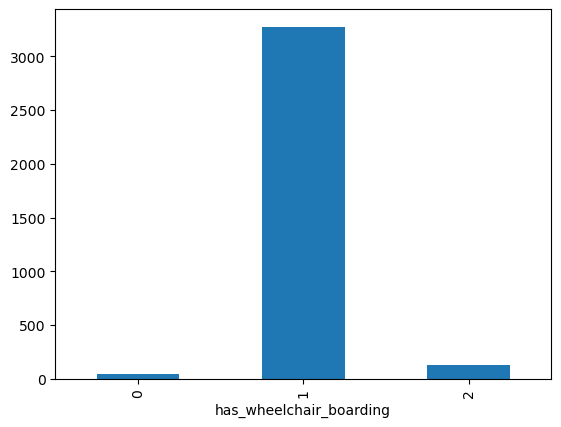

In [7]:
stops_df.groupby('has_wheelchair_boarding').size().plot.bar()

In [113]:
stops_with_wheelchairs_df = stops_df[stops_df['has_wheelchair_boarding'] == 1]
stops_with_wheelchairs_df.head()

,Unnamed: 0,id,stop_name,description,longitude,latitude,address,at_street,on_street,municipality,location_type,has_wheelchair_boarding,vehicle_type,neighborhood
1,1,2560,N Harvard St @ Kingsley St,NaN,-71.130333,42.361892,NaN,Franklin Street,North Harvard Street,Boston,0,1,3.0,Allston
2,2,333,E 1st St @ City Point Bus Terminal,NaN,-71.031327,42.338284,NaN,Busway,East First Street,Boston,0,1,3.0,South Boston
5,5,843,Lagrange St @ Dent St,NaN,-71.159686,42.281377,NaN,Dent Street,La Grange Street,Boston,0,1,3.0,West Roxbury
6,6,5219,Centre St @ Bradfield Ave,NaN,-71.140829,42.290298,NaN,Bradfield Avenue,Centre Street,Boston,0,1,3.0,Roslindale
10,10,1239,Tremont St @ Marginal St,NaN,-71.067595,42.348180,NaN,Church Street,Tremont Street,Boston,0,1,3.0,Chinatown


In [9]:
wheelchair_by_municipality_data = stops_with_wheelchairs_df.groupby('municipality')['has_wheelchair_boarding'].value_counts().unstack()

In [10]:
mbta_gdf = gpd.read_file(data_dir + '/MBTA_Systemwide_GTFS_Map/MBTA_Systemwide_GTFS_Map.shp')

In [11]:
stops_with_wheelchairs_df.shape

(3276, 13)

In [12]:
neighborhoods = [
    'Allston',
    'Back Bay',
    'Beacon Hill',
    'Brighton',
    'Charlestown',
    'Chinatown',
    'Dorchester',
    'Downtown',
    'East Boston',
    'Fenway',
    'Harbor Islands',
    'Hyde Park',
    'Jamaica Plain',
    'Longwood',
    'Mattapan',
    'Mission Hill',
    'North End',
    'Roslindale',
    'Roxbury',
    'South Boston',
    'South Boston Waterfront',
    'South End',
    'West End',
    'West Roxbury'
]

In [13]:
neighborhoods_gdf = gpd.read_file(data_dir + '/Census2020_BG_Neighborhoods/Census2020_BG_Neighborhoods.shp')

In [14]:
neighborhoods_df = gpd.read_file(data_dir + '/Census2020_BG_Neighborhoods/Boston_Neighborhood_Boundaries_Approximated_by_2020_Census_Tracts.csv')

In [15]:
first_row = stops_with_wheelchairs_df.iloc[0]

In [23]:
from shapely.geometry import Point
from pyproj import Transformer

transformer = Transformer.from_crs('EPSG:4326', neighborhoods_gdf.crs)
point = Point(transformer.transform(first_row['latitude'],first_row['longitude']))

print(point)
contains_polygon = neighborhoods_gdf[neighborhoods_gdf.geometry.contains(point)]
print(contains_polygon)

POINT (129323242.26628967 -4918060.638362028)
Empty GeoDataFrame
Columns: [OBJECTID, BlockGr202, Shape_Leng, Shape_Area, geometry]
Index: []


In [33]:
def get_neighborhood(row):
    transformer = Transformer.from_crs('EPSG:4326', neighborhoods_gdf.crs)
    point = Point(transformer.transform(row['latitude'], row['longitude']))    
    result = neighborhoods_gdf[neighborhoods_gdf.geometry.contains(point)]['BlockGr202']
    if not result.empty:
        neighborhood_value = result.iloc[0]
        return neighborhood_value
    else:
        return None

stops_with_wheelchairs_df['neighborhood'] = stops_with_wheelchairs_df.apply(get_neighborhood, axis=1)

/var/folders/m8/7lrhmxyj70s8cy7ldr_qzpj80000gn/T/ipykernel_21720/4062023598.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stops_with_wheelchairs_df['neighborhood'] = stops_with_wheelchairs_df.apply(get_neighborhood, axis=1)


In [40]:
stops_with_wheelchairs_df.dropna(subset=['neighborhood'], inplace=True)
stops_with_wheelchairs_df.to_csv(data_dir+ 'stops_with_neighborhood.csv')

/var/folders/m8/7lrhmxyj70s8cy7ldr_qzpj80000gn/T/ipykernel_21720/1687942254.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stops_with_wheelchairs_df.dropna(subset=['neighborhood'], inplace=True)


<Axes: title={'center': 'Stops with Wheelchairs'}, xlabel='Neighborhoods', ylabel='neighborhood'>

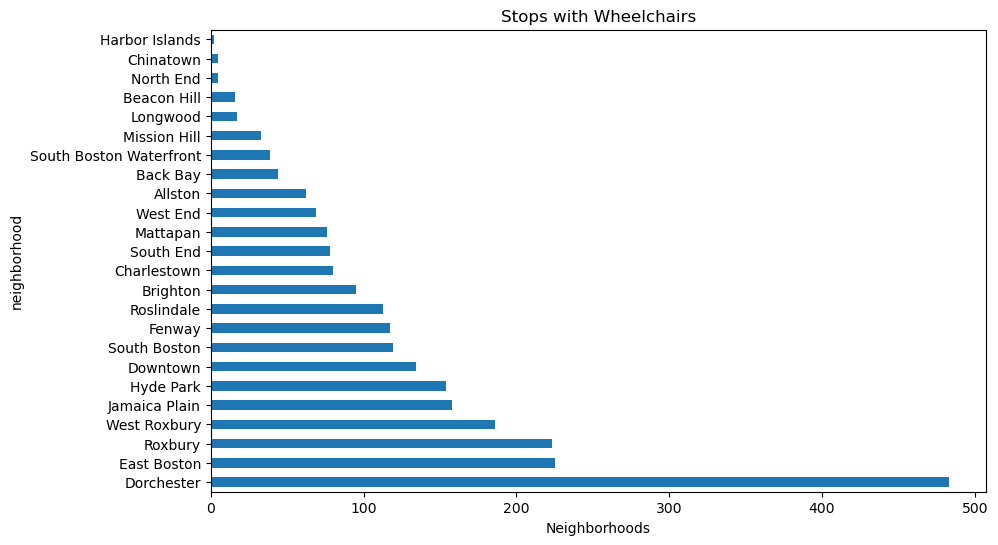

In [141]:
stops_with_wheelchairs_df.groupby('neighborhood').size().sort_values(ascending=False).plot(kind='barh', figsize=(10, 6), title='Stops with Wheelchairs', xlabel='Neighborhoods')

In [48]:
stops_df['neighborhood'] = stops_df.apply(get_neighborhood, axis=1)

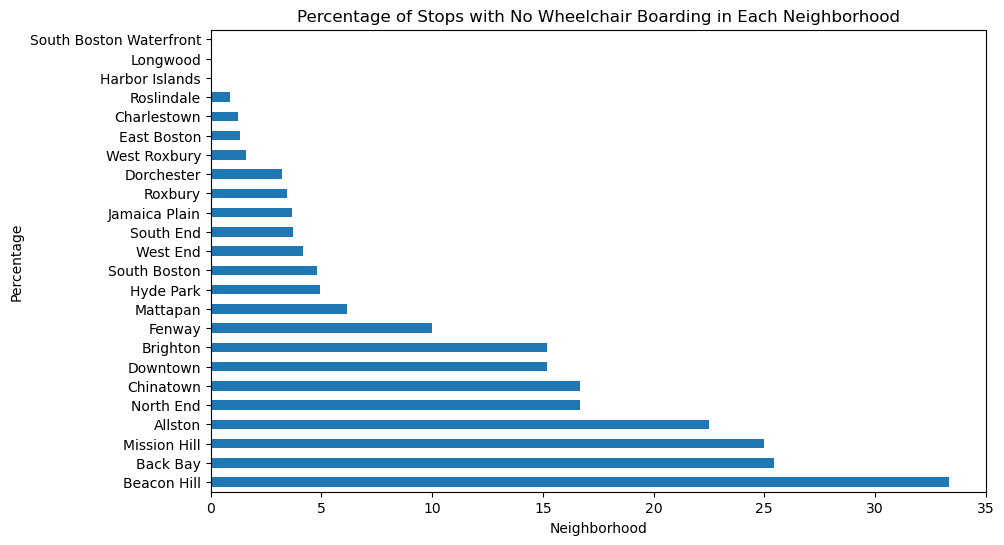

In [140]:
wheelchair_boarding_counts = stops_df[stops_df['has_wheelchair_boarding'] == 1].groupby('neighborhood').size()
no_wheelchair_boarding_counts = stops_df[stops_df['has_wheelchair_boarding'] != 1].groupby('neighborhood').size()
percentage_wheelchair_boarding = (no_wheelchair_boarding_counts / (wheelchair_boarding_counts + no_wheelchair_boarding_counts)) * 100

plt.figure(figsize=(10, 6))
percentage_wheelchair_boarding.sort_values(ascending=False).plot(kind='barh')
plt.title('Percentage of Stops with No Wheelchair Boarding in Each Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Percentage')
plt.show()

In [60]:
stops_df.head()

,Unnamed: 0,id,stop_name,description,longitude,latitude,address,at_street,on_street,municipality,location_type,has_wheelchair_boarding,vehicle_type,neighborhood
1,1,2560,N Harvard St @ Kingsley St,NaN,-71.130333,42.361892,NaN,Franklin Street,North Harvard Street,Boston,0,1,3.0,Allston
2,2,333,E 1st St @ City Point Bus Terminal,NaN,-71.031327,42.338284,NaN,Busway,East First Street,Boston,0,1,3.0,South Boston
5,5,843,Lagrange St @ Dent St,NaN,-71.159686,42.281377,NaN,Dent Street,La Grange Street,Boston,0,1,3.0,West Roxbury
6,6,5219,Centre St @ Bradfield Ave,NaN,-71.140829,42.290298,NaN,Bradfield Avenue,Centre Street,Boston,0,1,3.0,Roslindale
10,10,1239,Tremont St @ Marginal St,NaN,-71.067595,42.348180,NaN,Church Street,Tremont Street,Boston,0,1,3.0,Chinatown


In [159]:
import folium
from folium.plugins import MarkerCluster
from folium.features import DivIcon


boston_map = folium.Map(location=[42.320, -71.05], 
                        zoom_start=12, min_zoom=11, 
                        tiles='Cartodb Positron'
                       )


geojson_data = gpd.read_file(data_dir + 'census2020_bg_neighborhoods.json')

folium.GeoJson(geojson_data).add_to(boston_map)

bus_stops_df = stops_df.dropna(subset=['latitude', 'longitude'])


marker_cluster = MarkerCluster().add_to(boston_map)

color = {
    0: 'red',
    1: 'green',
    2: 'blue'
}

for index, row in bus_stops_df.iterrows():
    if row['latitude'] and row['longitude']:
        folium.CircleMarker(
            [row['latitude'], row['longitude']], 
            radius=1, 
            color=color[row['has_wheelchair_boarding']], 
            fill=True, 
            fill_opacity=1.0,
            fill_color=color[row['has_wheelchair_boarding']]).add_to(boston_map)
        
for idx, row in geojson_data.iterrows():
    neighborhood_name = row['BlockGr202']
    transformer = Transformer.from_crs('EPSG:2249', 'EPSG:4326')
    centroid = transformer.transform(row['geometry'].centroid.x, row['geometry'].centroid.y)
    folium.Marker(
        location=[centroid[0], centroid[1]], 
        icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(0,0),
        html='<div style="font-size:12pt;"><b>%s</b></div>' % neighborhood_name
        )
    ).add_to(boston_map)
    
boston_map

In [105]:
census_block_data = pd.read_csv('https://data.boston.gov/dataset/7846ff3b-b738-47a3-a57e-19de2c753220/resource/5800a0a2-6acd-41a3-9fe0-1bf7b038750d/download/redistricting_data_tract20_nbhd_hhpopsize_ab-1.csv')

In [106]:
census_block_data.columns

Index(['tract20_nbhd', 'P0020001', 'P0020005', 'P0020006', 'P0020002',
       'P002aapi', 'P002others', 'P0040001', 'P0040005', 'P0040006',
       'P0040002', 'P004aapi', 'P004others', 'P00x0001', 'P00x0005',
       'P00x0006', 'P00x0002', 'P00xaapi', 'P00xothers', 'hhpop', 'P0050001',
       'P0050002', 'P0050003', 'P0050004', 'P0050005', 'P0050006', 'P0050007',
       'P0050008', 'P0050009', 'P0050010', 'H0010001', 'H0010002', 'H0010003',
       'hhsize'],
      dtype='object')

In [108]:
census_block_data['tract20_nbhd'].unique().shape

(24,)

In [ ]:
routes_shp = gpd.read_file(data_dir + '/MBTA_Systemwide_GTFS_Map/MBTA_Systemwide_GTFS_Map.shp')